In [61]:
import pandas as pd
import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# kmeans
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import requests

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('Libraries imported.')

Libraries imported.


In [62]:
## Read Data from wikipedia

In [63]:

link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

tables = pd.read_html(link,header=0)

## Rename the column Neighburhood to Neighborhood in the dataframe

In [64]:
df = tables[0]
df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=1)


In [66]:
df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## Assign the value of Borough to Neighborhood for any role where the Neighborhood value is 'Not assigned'. Only one row in the dataframe has such

In [67]:
df.loc[df['Neighborhood']=="Not assigned",'Neighborhood']=df.loc[df['Neighborhood']=="Not assigned",'Borough']

In [68]:
df.shape

(288, 3)

## Replace value 'Not assigned' to 'NaN' so we can drop rows without a value

In [69]:
df.replace('Not assigned', np.NaN, inplace=True)
#seriesObj = df.apply(lambda x: x.isnull().any(), axis=1)
#numOfRows = len(seriesObj[seriesObj == True].index)
#numOfRows

In [75]:
df = df.dropna()

### Foursquare API credentials

In [188]:
VERSION = '20180605' # Foursquare API version

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


## Remove duplicate Postcode by combining duplicates row as one entry

In [98]:
df = pd.DataFrame(df.groupby(['Postcode','Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index())
df[:10]

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [77]:
#!conda install -c conda-forge geocoder --yes
import geocoder

### Using geocoder with arcgis to get the location coordinates. For some reason geocoder.google won't connect

In [78]:
def get_coords(row):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(row))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [187]:
coords = df['Postcode'].apply(get_coords).tolist()
coords[:10]

[[43.811525000000074, -79.19551721399995],
 [43.78573000000006, -79.15874999999994],
 [43.76569000000006, -79.17525603599995],
 [43.76835912100006, -79.21758999999997],
 [43.76968799900004, -79.23943999999995],
 [43.74312500000008, -79.23174973599998],
 [43.726244585000074, -79.26366999999993],
 [43.71313321100007, -79.28505499999994],
 [43.72357500000004, -79.23497617799995],
 [43.69666500000005, -79.26016331599999]]

### Add the columns Latitude and Longitude to the dataframe

In [80]:
df[['Latitude','Longitude']] = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [81]:
df.to_csv('Neighborhood_data.csv', index=False)

In [84]:
df_data = pd.read_csv('Neighborhood_data.csv')

In [85]:
df_data[:5]

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


## Exploration of the toronto dataset

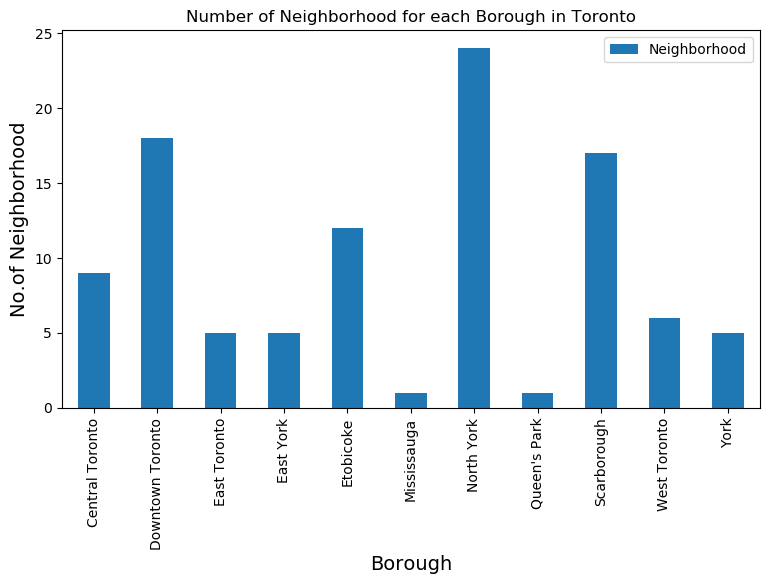

In [86]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in Toronto')
plt.xlabel('Borough', fontsize = 14)
plt.ylabel('No.of Neighborhood', fontsize=14)
df.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Function to get near by venues within the neighborhood

In [87]:
def getNearbyVenues(neighborhood, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(neighborhood, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( 
            name,
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['location']['formattedAddress'][0],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'ID',
                  'Address',
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [120]:
def get_venue_details(venue_id):

    venue_details=[]
    for vid in venue_id:
        #url to fetch data from foursquare api
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}&limit={}'.format(
                vid,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                5)

        # get all the data
        results = requests.get(url).json()
        venue_data=results['response']['venue']
        
        try:
            venue_id=venue_data['id']
            venue_name=venue_data['name']
            venue_rating=venue_data['rating']
            venue_likes=venue_data['likes']['count']
            venue_details.append([venue_id,venue_name,venue_rating,venue_likes])
        except KeyError:
            pass

    column_names=['ID','Name','Rating','Likes']
    df = pd.DataFrame([item for details in venue_details for item in details],columns=column_names)
    return df

In [89]:
venues = getNearbyVenues(df['Neighborhood'], df['Latitude'], df['Longitude'])


In [91]:
venues[:10]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Address,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Highland Creek,Rouge Hill,Port Union",43.785730,-79.158750,4c23d3aaf7ced13a5ed7216d,45 Lawson Rd,Royal Canadian Legion,43.782533,-79.163085,Bar
1,"Guildwood,Morningside,West Hill",43.765690,-79.175256,520194bd498edfb499b37b43,209 Manse Road.,The Strawberry Patch,43.764738,-79.173081,Tea Room
2,"Guildwood,Morningside,West Hill",43.765690,-79.175256,59574d48a4ba7c5751a65f86,88 Homestead Rd,Homestead Roofing Repair,43.765140,-79.178663,Construction & Landscaping
3,"Guildwood,Morningside,West Hill",43.765690,-79.175256,4b114be3f964a520e57923e3,292 Manse Rd. (at Lawrence Ave. E),Heron Park Community Centre,43.768867,-79.176958,Gym / Fitness Center
4,"Guildwood,Morningside,West Hill",43.765690,-79.175256,4e582aceb61c5534c28c2691,Manse (Lawrence),Heron Park,43.769327,-79.177201,Park
5,Woburn,43.768359,-79.217590,4cc1d28c06c254815ac18547,300 Borough Dr (Scarborough Town Centre),Starbucks,43.770037,-79.221156,Coffee Shop
6,Woburn,43.768359,-79.217590,5a8b831ce1f0aa07a1f26be3,Barnes Crescent,cheapOseo,43.766042,-79.218539,Business Service
7,Woburn,43.768359,-79.217590,4de0403ed4c040523ea079f4,369 Yonge Street,Korean Grill House,43.770812,-79.214502,Korean Restaurant
8,Woburn,43.768359,-79.217590,4e9a57ac754aab1ca9c20a47,Scarborough,Densgrove Park,43.765397,-79.220130,Park
9,Cedarbrae,43.769688,-79.239440,4cbf64e997bc721e0c3f8567,Toronto ON,North Bendale Park,43.769963,-79.245265,Playground


In [92]:
venues.to_csv('neighborhood_venues.csv')

In [94]:
venues = pd.read_csv('neighborhood_venues.csv', index_col=0)

In [96]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Address,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Highland Creek,Rouge Hill,Port Union",43.78573,-79.158750,4c23d3aaf7ced13a5ed7216d,45 Lawson Rd,Royal Canadian Legion,43.782533,-79.163085,Bar
1,"Guildwood,Morningside,West Hill",43.76569,-79.175256,520194bd498edfb499b37b43,209 Manse Road.,The Strawberry Patch,43.764738,-79.173081,Tea Room
2,"Guildwood,Morningside,West Hill",43.76569,-79.175256,59574d48a4ba7c5751a65f86,88 Homestead Rd,Homestead Roofing Repair,43.765140,-79.178663,Construction & Landscaping
3,"Guildwood,Morningside,West Hill",43.76569,-79.175256,4b114be3f964a520e57923e3,292 Manse Rd. (at Lawrence Ave. E),Heron Park Community Centre,43.768867,-79.176958,Gym / Fitness Center
4,"Guildwood,Morningside,West Hill",43.76569,-79.175256,4e582aceb61c5534c28c2691,Manse (Lawrence),Heron Park,43.769327,-79.177201,Park


## Now we need to get neighborhoods where we can find restaurants

In [126]:
#venues['Venue Category']
neighborhood_restaurant = venues.loc[venues['Venue Category']=='Restaurant']
neighborhood_restaurant = neighborhood_restaurant.loc[:,:]
neighborhood_restaurant[:10]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Address,Venue,Venue Latitude,Venue Longitude,Venue Category
11,Scarborough Village,43.743125,-79.231750,4bb3e779f187a593b89e13f8,2990 Eglinton Ave E,Swiss Chalet Rotisserie & Grill,43.740378,-79.232656,Restaurant
118,"Fairview,Henry Farm,Oriole",43.780880,-79.347796,5650fa8e498e405c38a5e6d4,"1800 Sheppard Ave E,Fairview Mall",Thai Express,43.777990,-79.344091,Restaurant
320,Leaside,43.709765,-79.363901,53c95181498ec1d30073384e,190 Laird Drive (Wicksteed Avenue),The Leaside Pub,43.710429,-79.363547,Restaurant
474,Davisville,43.703395,-79.385964,58a881442520ae596a926970,505 Mount Pleasant Road,Starving Artist,43.701538,-79.387240,Restaurant
500,"Cabbagetown,St. James Town",43.668160,-79.366602,5412007d498e1e2d959ac35e,568 Parliament St. (Wellesley),Murgatroid,43.667381,-79.369311,Restaurant
512,"Cabbagetown,St. James Town",43.668160,-79.366602,4ad4c05ff964a5202df720e3,507 Parliament St,The Pear Tree,43.664904,-79.368246,Restaurant
539,Church and Wellesley,43.666585,-79.381302,4caf69ae9b34199c9a2ab763,519 Church Street (at Wellesley),Fabarnak,43.666377,-79.380964,Restaurant
579,Church and Wellesley,43.666585,-79.381302,4bdcc9cf462b2d7f1f65113c,3 Charles St E (at Yonge),Wish,43.668759,-79.385694,Restaurant
581,Church and Wellesley,43.666585,-79.381302,4ae09a2af964a520d58021e3,620 Church St (Charles St E),O. Noir,43.669145,-79.382505,Restaurant
611,Church and Wellesley,43.666585,-79.381302,4b5f4b63f964a52074b229e3,175 Bloor St E (at Church St.),Sushi Shop,43.670694,-79.382508,Restaurant


## We need to find what Borough the resaturants belong to

In [127]:
tor_borough_merged = df.iloc[:,1:]

tor_restaurants = pd.merge(tor_borough_merged, neighborhood_restaurant, on=['Neighborhood'], how='inner')
tor_restaurants.head()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#tor_borough_merged = tor_borough_merged.join(neighborhood_restaurant.set_index('Neighborhood'), on='Neighborhood')

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Address,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,Scarborough Village,43.743125,-79.231750,4bb3e779f187a593b89e13f8,2990 Eglinton Ave E,Swiss Chalet Rotisserie & Grill,43.740378,-79.232656,Restaurant
1,North York,"Fairview,Henry Farm,Oriole",43.780880,-79.347796,5650fa8e498e405c38a5e6d4,"1800 Sheppard Ave E,Fairview Mall",Thai Express,43.777990,-79.344091,Restaurant
2,East York,Leaside,43.709765,-79.363901,53c95181498ec1d30073384e,190 Laird Drive (Wicksteed Avenue),The Leaside Pub,43.710429,-79.363547,Restaurant
3,Central Toronto,Davisville,43.703395,-79.385964,58a881442520ae596a926970,505 Mount Pleasant Road,Starving Artist,43.701538,-79.387240,Restaurant
4,Downtown Toronto,"Cabbagetown,St. James Town",43.668160,-79.366602,5412007d498e1e2d959ac35e,568 Parliament St. (Wellesley),Murgatroid,43.667381,-79.369311,Restaurant


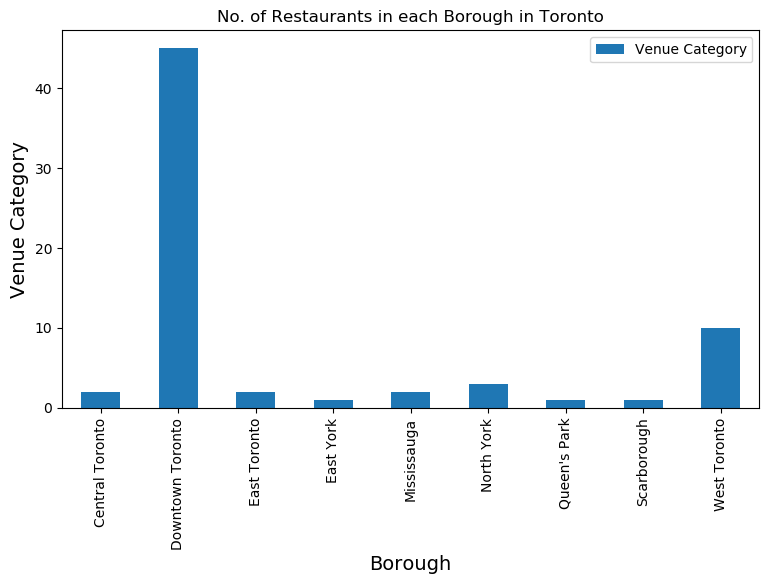

In [170]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('No. of Restaurants in each Borough in Toronto')
plt.xlabel('Borough', fontsize = 14)
plt.ylabel('Venue Category', fontsize=14)
tor_restaurants.groupby('Borough')['Venue Category'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Let's focus on the Downtown Toronto Borough and See the restaurants in there

In [186]:
downtown_restaurants = tor_restaurants.loc[tor_restaurants['Borough'] == 'Downtown Toronto']
downtown_restaurants[:10]

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Address,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Downtown Toronto,"Cabbagetown,St. James Town",43.668160,-79.366602,5412007d498e1e2d959ac35e,568 Parliament St. (Wellesley),Murgatroid,43.667381,-79.369311,Restaurant
5,Downtown Toronto,"Cabbagetown,St. James Town",43.668160,-79.366602,4ad4c05ff964a5202df720e3,507 Parliament St,The Pear Tree,43.664904,-79.368246,Restaurant
6,Downtown Toronto,Church and Wellesley,43.666585,-79.381302,4caf69ae9b34199c9a2ab763,519 Church Street (at Wellesley),Fabarnak,43.666377,-79.380964,Restaurant
7,Downtown Toronto,Church and Wellesley,43.666585,-79.381302,4bdcc9cf462b2d7f1f65113c,3 Charles St E (at Yonge),Wish,43.668759,-79.385694,Restaurant
8,Downtown Toronto,Church and Wellesley,43.666585,-79.381302,4ae09a2af964a520d58021e3,620 Church St (Charles St E),O. Noir,43.669145,-79.382505,Restaurant
9,Downtown Toronto,Church and Wellesley,43.666585,-79.381302,4b5f4b63f964a52074b229e3,175 Bloor St E (at Church St.),Sushi Shop,43.670694,-79.382508,Restaurant
10,Downtown Toronto,"Harbourfront,Regent Park",43.655120,-79.362640,5612b1cc498e3dd742af0dc8,573 King St E (at St Lawrence St),Impact Kitchen,43.656369,-79.356980,Restaurant
11,Downtown Toronto,"Harbourfront,Regent Park",43.655120,-79.362640,51c085d3498eadedb67ba6cd,506 Queen St E (Sumach St),Flame Shack,43.656844,-79.358917,Restaurant
12,Downtown Toronto,"Ryerson,Garden District",43.657363,-79.378180,59246b5aad1789316b35d66c,1 Dundas St W,JOEY Eaton Centre,43.655404,-79.381929,Restaurant
13,Downtown Toronto,"Ryerson,Garden District",43.657363,-79.378180,4ad9ffbbf964a520091d21e3,10 Dundas St. E (at Yonge St.),Jack Astor's Bar & Grill,43.656019,-79.380326,Restaurant


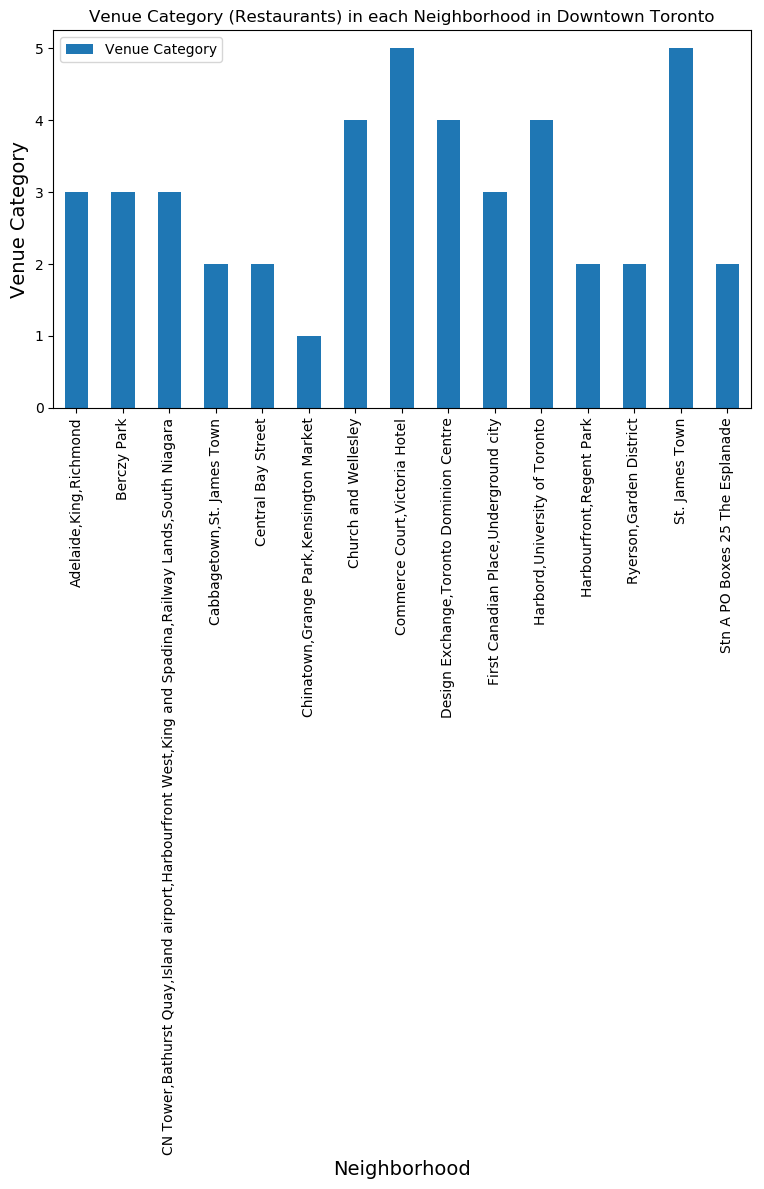

In [190]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Venue Category (Restaurants) in each Neighborhood in Downtown Toronto')
plt.xlabel('Neighborhood', fontsize = 14)
plt.ylabel('Venue Category', fontsize=14)
downtown_restaurants.groupby('Neighborhood')['Venue Category'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [167]:
# FOURSQUARE API DAILY CALLS RESTRICTION
#venues_details = get_venue_details(downtown_restaurants['ID'])
#venues_details.to_csv('venues_details')

## ANalyzing Neighborhood

In [149]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_restaurants[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_onehot[['Neighborhood', 'Address']] = downtown_restaurants[['Neighborhood', 'Address']]

# move neighborhood column to the first column
downtown_onehot_columns = list(downtown_onehot)
downtown_onehot_columns.insert(0, downtown_onehot_columns.pop(downtown_onehot_columns.index('Neighborhood')))
downtown_onehot_columns.insert(1, downtown_onehot_columns.pop(downtown_onehot_columns.index('Address')))

downtown_onehot = downtown_onehot.loc[:, downtown_onehot_columns]

downtown_onehot[:10]

,Neighborhood,Address,Bannock,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack,GEORGE Restaurant,Harvest Kitchen,Helena's Magic Kitchen,Impact Kitchen,JOEY Eaton Centre,Jack Astor's Bar & Grill,Kellys Landing,Marché Mövenpick,Murgatroid,O. Noir,Portland Variety,Rasa,Real Mo-Mo's,Sushi Shop,The Carbon Bar,The Pear Tree,The Works Gourmet Burger Bistro,U Tea Bubble Tea & Board Games,Victoria's Restaurant,Wish
4,"Cabbagetown,St. James Town",568 Parliament St. (Wellesley),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,"Cabbagetown,St. James Town",507 Parliament St,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,Church and Wellesley,519 Church Street (at Wellesley),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Church and Wellesley,3 Charles St E (at Yonge),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,Church and Wellesley,620 Church St (Charles St E),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,Church and Wellesley,175 Bloor St E (at Church St.),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10,"Harbourfront,Regent Park",573 King St E (at St Lawrence St),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,"Harbourfront,Regent Park",506 Queen St E (Sumach St),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,"Ryerson,Garden District",1 Dundas St W,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,"Ryerson,Garden District",10 Dundas St. E (at Yonge St.),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Group rows by Neighborhood by taking the mean of the frequency of occurrence of each category

In [179]:
downtown_grouped = downtown_onehot.groupby('Neighborhood').mean().reset_index()
downtown_grouped

,Neighborhood,Bannock,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack,GEORGE Restaurant,Harvest Kitchen,Helena's Magic Kitchen,Impact Kitchen,JOEY Eaton Centre,Jack Astor's Bar & Grill,Kellys Landing,Marché Mövenpick,Murgatroid,O. Noir,Portland Variety,Rasa,Real Mo-Mo's,Sushi Shop,The Carbon Bar,The Pear Tree,The Works Gourmet Burger Bistro,U Tea Bubble Tea & Board Games,Victoria's Restaurant,Wish
0,"Adelaide,King,Richmond",0.333333,0.00,0.000000,0.333333,0.333333,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.00
1,Berczy Park,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.333333,0.0,0.00,0.000000,0.00,0.333333,0.00,0.0,0.0,0.333333,0.00,0.0,0.00
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.000000,0.00,0.333333,0.000000,0.000000,0.333333,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.333333,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.00
3,"Cabbagetown,St. James Town",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.5,0.00,0.000000,0.00,0.000000,0.00,0.0,0.5,0.000000,0.00,0.0,0.00
4,Central Bay Street,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.5,0.5,0.00,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.00
5,"Chinatown,Grange Park,Kensington Market",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.00
6,Church and Wellesley,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.25,0.000000,0.00,0.000000,0.25,0.0,0.0,0.000000,0.00,0.0,0.25
7,"Commerce Court,Victoria Hotel",0.000000,0.00,0.000000,0.200000,0.200000,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.200000,0.0,0.00,0.000000,0.00,0.200000,0.00,0.0,0.0,0.000000,0.00,0.2,0.00
8,"Design Exchange,Toronto Dominion Centre",0.000000,0.00,0.000000,0.250000,0.250000,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.25,0.250000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.00
9,"First Canadian Place,Underground city",0.000000,0.00,0.000000,0.333333,0.333333,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.333333,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.00


## Most common Venues within the Downtown Tooronto Neighborhood

In [180]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [182]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
downtown_neigh_sorted = pd.DataFrame(columns=columns)
downtown_neigh_sorted['Neighborhood'] = downtown_grouped['Neighborhood']

for ind in np.arange(downtown_grouped.shape[0]):
    downtown_neigh_sorted.iloc[ind, 1:] = most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)


downtown_neigh_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Bannock,Bymark,Canoe,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak,Flame Shack,GEORGE Restaurant
1,Berczy Park,The Works Gourmet Burger Bistro,Real Mo-Mo's,Marché Mövenpick,Wish,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Big Smoke Burger,Colette Grand Café,Portland Variety,Wish,JOEY Eaton Centre,Bar Mercurio,Bymark,Canoe,Fabarnak,Flame Shack
3,"Cabbagetown,St. James Town",The Pear Tree,Murgatroid,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak
4,Central Bay Street,Jack Astor's Bar & Grill,JOEY Eaton Centre,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack


## Cluster the Neighborhoods

In [183]:
# set number of clusters
kclusters = 5

downtown_grouped_clustering = downtown_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 3, 4, 0, 1, 1, 1], dtype=int32)

In [184]:
# add clustering labels
downtown_neigh_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_neigh_merged = downtown_restaurants.iloc[:,1:4]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downtown_neigh_merged = downtown_neigh_merged.join(downtown_neigh_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_neigh_merged.dropna(inplace=True)
downtown_neigh_merged[:10] # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Cabbagetown,St. James Town",43.668160,-79.366602,0,The Pear Tree,Murgatroid,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak
5,"Cabbagetown,St. James Town",43.668160,-79.366602,0,The Pear Tree,Murgatroid,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak
6,Church and Wellesley,43.666585,-79.381302,0,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
7,Church and Wellesley,43.666585,-79.381302,0,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
8,Church and Wellesley,43.666585,-79.381302,0,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
9,Church and Wellesley,43.666585,-79.381302,0,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
10,"Harbourfront,Regent Park",43.655120,-79.362640,2,Flame Shack,Impact Kitchen,Wish,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak
11,"Harbourfront,Regent Park",43.655120,-79.362640,2,Flame Shack,Impact Kitchen,Wish,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak
12,"Ryerson,Garden District",43.657363,-79.378180,3,Jack Astor's Bar & Grill,JOEY Eaton Centre,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack
13,"Ryerson,Garden District",43.657363,-79.378180,3,Jack Astor's Bar & Grill,JOEY Eaton Centre,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack


## Let's now go ahead and VISUALIZE CLUSTER ON A LEAFLET MAP

In [155]:
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.655115, -79.380219.


In [158]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_neigh_merged['Neighborhood Latitude'], downtown_neigh_merged['Neighborhood Longitude'], downtown_neigh_merged['Neighborhood'], downtown_neigh_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [192]:
downtown_neigh_merged.loc[downtown_neigh_merged['Cluster Labels'] == 0, downtown_neigh_merged.columns[[0] + list(range(4, downtown_neigh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Cabbagetown,St. James Town",The Pear Tree,Murgatroid,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak
5,"Cabbagetown,St. James Town",The Pear Tree,Murgatroid,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak
6,Church and Wellesley,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
7,Church and Wellesley,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
8,Church and Wellesley,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
9,Church and Wellesley,Wish,Sushi Shop,Fabarnak,O. Noir,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café
14,St. James Town,Bannock,The Works Gourmet Burger Bistro,The Carbon Bar,GEORGE Restaurant,Victoria's Restaurant,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Bymark,Canoe
15,St. James Town,Bannock,The Works Gourmet Burger Bistro,The Carbon Bar,GEORGE Restaurant,Victoria's Restaurant,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Bymark,Canoe
16,St. James Town,Bannock,The Works Gourmet Burger Bistro,The Carbon Bar,GEORGE Restaurant,Victoria's Restaurant,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Bymark,Canoe
17,St. James Town,Bannock,The Works Gourmet Burger Bistro,The Carbon Bar,GEORGE Restaurant,Victoria's Restaurant,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Bymark,Canoe


In [193]:
downtown_neigh_merged.loc[downtown_neigh_merged['Cluster Labels'] == 1, downtown_neigh_merged.columns[[0] + list(range(4, downtown_neigh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,"Adelaide,King,Richmond",Bannock,Bymark,Canoe,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak,Flame Shack,GEORGE Restaurant
25,"Adelaide,King,Richmond",Bannock,Bymark,Canoe,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak,Flame Shack,GEORGE Restaurant
26,"Adelaide,King,Richmond",Bannock,Bymark,Canoe,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak,Flame Shack,GEORGE Restaurant
27,"Design Exchange,Toronto Dominion Centre",Bymark,Canoe,Marché Mövenpick,Kellys Landing,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak
28,"Design Exchange,Toronto Dominion Centre",Bymark,Canoe,Marché Mövenpick,Kellys Landing,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak
29,"Design Exchange,Toronto Dominion Centre",Bymark,Canoe,Marché Mövenpick,Kellys Landing,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak
30,"Design Exchange,Toronto Dominion Centre",Bymark,Canoe,Marché Mövenpick,Kellys Landing,Wish,JOEY Eaton Centre,Bar Mercurio,Big Smoke Burger,Colette Grand Café,Fabarnak
31,"Commerce Court,Victoria Hotel",Bymark,Canoe,Real Mo-Mo's,Marché Mövenpick,Victoria's Restaurant,Wish,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Colette Grand Café
32,"Commerce Court,Victoria Hotel",Bymark,Canoe,Real Mo-Mo's,Marché Mövenpick,Victoria's Restaurant,Wish,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Colette Grand Café
33,"Commerce Court,Victoria Hotel",Bymark,Canoe,Real Mo-Mo's,Marché Mövenpick,Victoria's Restaurant,Wish,Impact Kitchen,Bar Mercurio,Big Smoke Burger,Colette Grand Café


In [164]:
downtown_neigh_merged.loc[downtown_neigh_merged['Cluster Labels'] == 3, downtown_neigh_merged.columns[[0] + list(range(4, downtown_neigh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Ryerson,Garden District",Jack Astor's Bar & Grill,JOEY Eaton Centre,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack
13,"Ryerson,Garden District",Jack Astor's Bar & Grill,JOEY Eaton Centre,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack
22,Central Bay Street,Jack Astor's Bar & Grill,JOEY Eaton Centre,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack
23,Central Bay Street,Jack Astor's Bar & Grill,JOEY Eaton Centre,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack


In [165]:
downtown_neigh_merged.loc[downtown_neigh_merged['Cluster Labels'] == 4, downtown_neigh_merged.columns[[0] + list(range(4, downtown_neigh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,"Chinatown,Grange Park,Kensington Market",Helena's Magic Kitchen,Wish,Victoria's Restaurant,Bar Mercurio,Big Smoke Burger,Bymark,Canoe,Colette Grand Café,Fabarnak,Flame Shack
